In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import *
from sklearn.model_selection import *
import statsmodels.api as sm
import scipy.stats as stats

%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:
            
import regex as re
import requests
from bs4 import BeautifulSoup

ModuleNotFoundError: No module named 'sql'

# Project Phase IV

### Introduction

Why are life expectancies higher in some countries than others?

By analyzing socioeconomic factors like violent crime rates, healthcare, diet, economic development, genetics, and happiness level, we will be able to learn more about which factors influence life expectancy and which do not. We later find that calorie consumption, education levels, income levels, and happiness levels each individually have statistically significant results that they tend to increase life expectancies in a country. Our tests additionally were inconclusive on whether or not having universal healthcare in a country increased its life expectancy. Lastly, we looked to data within our dataset to determine how to maximize life expectancy in a country, according to our model, and creating a country that would have the highest life expectancy. 

Knowing which of these factors are strong can be valueable when deciding how a government should spend and write policies to increase the life span of their citizens. Weak factors can also benefit goverment decision making by possibly reducing the amount of effort spent in these regards, if they intend to maximize life expectancy.

Lastly, one can extrapolate the country data to infer more individualized insights. If these factors on average within a given country correlate to the country having a higher life expectancy, perhaps they can also indicate ways to increase an individual's life expectancy. Although this hypothesis is not tested in this project, future research can be done in estimating an individual's life expectancy based on their behaviors and environment.

# Data Description
- What are the observations (rows) and the attributes (columns)? <br>
On the vertical we have countries, with their respective data in the columns. Columns include `Life Expectancy`, `Homicide Rate`, `Mean years of schooling`, etc. Every column other than the country's names is a float, with null values set as -99.9 to allow for simple sorting. 
- Why was this dataset created? <br>
This dataset was created to investigate life expectancy and its relationships with macroeconimic and societal factors, such as GNI per capita, level of education, diet, happiness, etc.
- What processes might have influenced what data was observed and recorded and what was not? <br>
Our dataset consists of data gathered in recent years and in countries around the world. This has an adverse effect on the quality of the data, given that the pandemic likely negatively impacted life expectancies. It is also important to note that certain countries, especially smaller ones or those that are more protective with their data, often had missing or old data points. 
- What preprocessing was done, and how did the data come to be in the form that you are using? <br>
Much of the preprocessing had to do trying to combine datasets from varying sources, each with their own ways of categorizing data (such as UN's labelling of certain countries as "high human development", etc.) that introduce additional, not-so-relevant data into the middle of every couple of rows. Another massive issue was the various names that countries can go by. The United States, for example, can go as `USA`, `United States`, `The United States of America`, etc.
- Where can your raw source data be found, if applicable? Provide a link to the raw data (hosted in a Cornell Google Drive or Cornell Box). <br>
All datasets have their links attached throughout this notebook, with some copies in the `data` folder in this project.

# Basic Data Analysis

Here we have basic summary statistics of the data found.

In [4]:
df_final = pd.read_csv("data/final.csv")
df_final.head()

,Country,Life Expectancy,Homicide Rate,Mean years of schooling,Gross national income (GNI) per capita,kg meat/person,cal,has_uhc,happiness_index,genetic_index,level of human development
0,Albania,78.686,2.29,11.286455,14131.11039,47.51,3360.0,1.0,5.117,11.4,3
1,United Arab Emirates,78.120,0.46,12.694030,62573.59181,62.03,3314.0,1.0,6.561,18.5,4
2,Argentina,76.813,5.32,11.147269,20925.26814,109.39,3307.0,1.0,5.929,15.7,4
3,Armenia,75.224,1.69,11.330300,13157.99390,45.64,2997.0,0.0,5.283,19.9,3
4,Australia,83.200,0.89,12.726820,49238.43335,121.61,3391.0,1.0,7.183,8.6,4


### Summary Statistics

In [5]:
df_final.describe()

,Life Expectancy,Homicide Rate,Mean years of schooling,Gross national income (GNI) per capita,kg meat/person,cal,has_uhc,happiness_index,genetic_index,level of human development
count,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000
mean,74.181112,6.087523,9.538524,22451.396131,49.363211,2957.293578,0.541284,5.671046,17.846789,2.990826
std,6.934363,10.228273,3.063096,19594.529183,29.018068,452.467500,0.500594,1.062122,6.897471,1.084362
min,54.836000,0.260000,2.114962,1198.073924,3.780000,1908.000000,0.000000,3.145000,7.900000,1.000000
25%,70.056000,1.170000,7.192013,6589.980037,20.340000,2662.000000,0.000000,4.934000,11.000000,2.000000
50%,75.387805,2.200000,10.427910,15241.914650,53.490000,3019.000000,1.000000,5.813000,17.800000,3.000000
75%,79.208000,5.370000,12.191084,37931.303590,73.010000,3322.000000,1.000000,6.317000,22.600000,4.000000
max,84.615610,52.020000,14.090967,84649.474670,121.610000,3885.000000,1.000000,7.842000,42.700000,4.000000


# Preregistration 

We will analyze several socioeconomic factors and determine how stastically signficant they are to life expectancy. The questions will try to answer are:
- Do people that eat more live longer? 
- Are more educated people living longer? 
- Do people with higher income live longer?
- Are happier people living longer?
- Do countries with universal healthcare have longer living citizens?

# Single Variable Analysis & Evaluation of Significance

## Do people that eat more live longer?
   * H0: People from a country that has a higher consumption live as long as others on average.
   * HA: People from countries that eat more on average live longer than those from countries with less consumption. 

In [6]:
df_final = pd.read_csv("data/final.csv")
df_h1 = df_final[["Life Expectancy","cal","Country"]].sort_values('cal')
df_h1.head()

,Life Expectancy,cal,Country
108,61.738,1908.0,Zimbabwe
102,63.713,1981.0,Uganda
107,64.194,2002.0,Zambia
70,61.387,2103.0,Mozambique
99,71.301,2109.0,Tajikistan


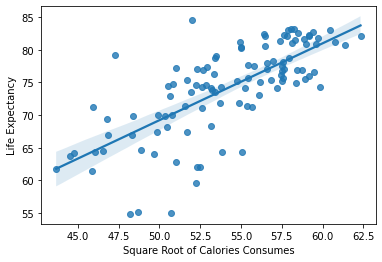

Slope of Model: [1.14425723] 
Intercept of Model: 11.827876356512661
Train RMSE: 5.051052218121081 
Test RMSE: 3.5655259656815677


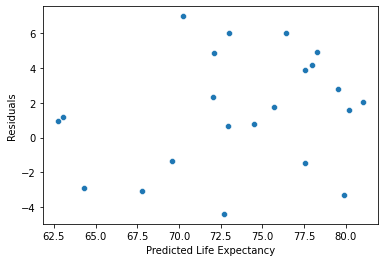

                                 OLS Regression Results                                
Dep. Variable:        Life Expectancy   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          2.546e+04
Date:                Sun, 20 Nov 2022   Prob (F-statistic):                   4.70e-130
Time:                        16:14:09   Log-Likelihood:                         -326.59
No. Observations:                 109   AIC:                                      655.2
Df Residuals:                     108   BIC:                                      657.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [7]:
#Used sqrt transformation because data showed strong curve
X = np.sqrt(df_h1["cal"].to_numpy().reshape(-1,1))
y = (df_h1["Life Expectancy"])
sns.regplot(x = X,y = y).set(xlabel='Square Root of Calories Consumes', ylabel='Life Expectancy')
plt.show()
calories_train, calories_test, exp_train, exp_test = train_test_split(X, y, test_size=0.2, random_state=10)
model_h1 = LinearRegression().fit(calories_train,exp_train)
train_predictions = model_h1.predict(calories_train)
test_predictions = model_h1.predict(calories_test)
train_residuals = exp_train - train_predictions
test_residuals = exp_test - test_predictions
print("Slope of Model:",model_h1.coef_,"\nIntercept of Model:",model_h1.intercept_)
train_rmse = np.sqrt(np.mean(train_residuals**2))
test_rmse = np.sqrt(np.mean(test_residuals**2))
print("Train RMSE:",train_rmse,"\nTest RMSE:",test_rmse)
sns.scatterplot(x = test_predictions, y = test_residuals).set(xlabel='Predicted Life Expectancy', ylabel='Residuals')
plt.show()
OLS_model_h1 = sm.OLS(y, X).fit()
print(OLS_model_h1.summary())
print("\nRight-sided P-Value at 97.5% CL:",OLS_model_h1.t_test(1).pvalue)

After transforming the calorie data by square rooting it, our linear regression yields an R squared value of 0.996, suggesting very strong correlation between the square root of calories consumed on average by a country and that country's life expectancy. Our train RMSE is higher than our test RMSE which also suggests that our model is not overfitting. Additionally, when running a correlation test to analyze our hypothesis, we can reject the null hypothesis and predict that countries with higher average calorie consumption have higher life expectancies with a confidence level of 97.5%. Because our two-sided test with CL 95% yields a p-value of approximately 0, we can conclude that our right-side test would have the same p-value with a CL of 97.5%. This gives us a type I error proability of 2.5%. Our model intercept suggests that someone who eats 0 calories a day will live a predicted 10 years, which is an oddity of our model that is unrealistic and clearly untrue. Our slope suggests that for each square root calorie increases the life expectancy prediction by 1.18 years.

## Are more educated people living longer?
* We will use `Mean years of schooling` as a metric for level of education.
* H0: A country’s average education level does not affect their citizens’ life expectancies.
* HA: People from countries with higher average education levels live longer. 

In [8]:
df_h2 = df_final[["Life Expectancy","Mean years of schooling","Country"]].sort_values('Mean years of schooling')
df_h2.head()

,Life Expectancy,Mean years of schooling,Country
9,61.981,2.114962,Burkina Faso
75,62.792,2.116717,Niger
92,68.213,2.937938,Senegal
70,61.387,3.197642,Mozambique
31,66.953,3.201521,Ethiopia


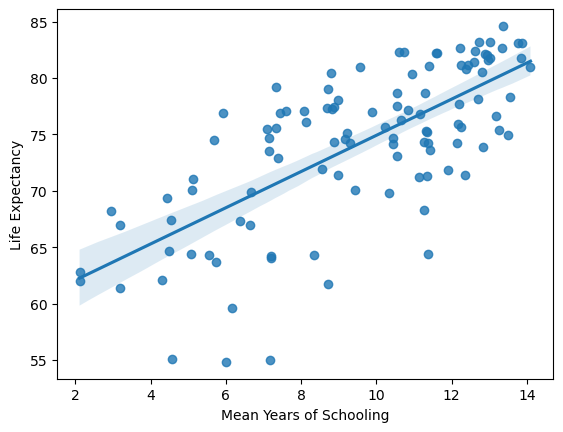

Slope of Model: [1.73537419] 
Intercept of Model: 57.2440364661451
Train RMSE: 5.041004855071486 
Test RMSE: 4.286073970760854


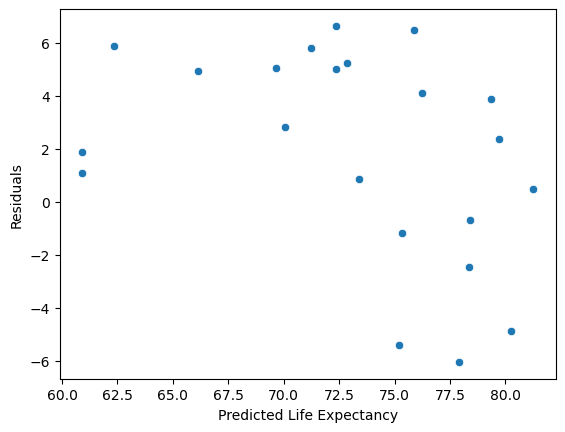

                                 OLS Regression Results                                
Dep. Variable:        Life Expectancy   R-squared (uncentered):                   0.938
Model:                            OLS   Adj. R-squared (uncentered):              0.937
Method:                 Least Squares   F-statistic:                              1630.
Date:                Sun, 20 Nov 2022   Prob (F-statistic):                    5.54e-67
Time:                        13:19:23   Log-Likelihood:                         -473.13
No. Observations:                 109   AIC:                                      948.3
Df Residuals:                     108   BIC:                                      951.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [9]:
X = (df_h2["Mean years of schooling"].to_numpy().reshape(-1,1))
y = (df_h2["Life Expectancy"])
sns.regplot(x = X,y = y).set(xlabel='Mean Years of Schooling', ylabel='Life Expectancy')
plt.show()
schooling_train, schooling_test, exp_train, exp_test = train_test_split(X, y, test_size=0.2, random_state=18)
model_h2 = LinearRegression().fit(schooling_train,exp_train)
train_predictions = model_h2.predict(schooling_train)
test_predictions = model_h2.predict(schooling_test)
train_residuals = exp_train - train_predictions
test_residuals = exp_test - test_predictions
print("Slope of Model:",model_h2.coef_,"\nIntercept of Model:",model_h2.intercept_)
train_rmse = np.sqrt(np.mean(train_residuals**2))
test_rmse = np.sqrt(np.mean(test_residuals**2))
print("Train RMSE:",train_rmse,"\nTest RMSE:",test_rmse)
sns.scatterplot(x = test_predictions, y = test_residuals).set(xlabel='Predicted Life Expectancy', ylabel='Residuals')
plt.show()
OLS_model_h2 = sm.OLS(y, X).fit()
print(OLS_model_h2.summary())
print("\nRight-sided P-Value at 97.5% CL:",OLS_model_h2.t_test(1).pvalue)

Our linear regression yields an R squared value of 0.938, suggesting strong correlation between the mean years of schooling by a country and that country's life expectancy. Our train RMSE is higher than our test RMSE which also suggests that our model is not overfitting. Additionally, when running a correlation test to analyze our hypothesis, we can reject the null hypothesis and predict that countries with longer average schooling have higher life expectancies with a confidence level of 97.5%. Because our two-sided test with CL 95% yields a p-value of approximately 0, we can conclude that our right-side test would have the same p-value with a CL of 97.5%. This gives us a type I error probability of 2.5%. The model intercepts predicts that a country with 0 years of average schooling would have a life expectancy of 57 years. The model also predicts that each one year increase in a country's average education will increase their life expectancy by 1.74 years.

## Do people in first world countries live longer?
##### Adapted from Hypothesis 3 in Phase 3
* We will use `GNI per capita` as a metric, given that the UN's calculations for `Level of human development` (whether a country is highly developed/first world or not) already use life expectancy itself as an input.
* H0: Economic development (GNI) does not affect longevity. 
* HA: People in more economically developed countries live longer than people in developing countries.

In [10]:
df_h3 = df_final[["Life Expectancy","Gross national income (GNI) per capita","Country"]].sort_values("Gross national income (GNI) per capita")
df_h3.head()

,Life Expectancy,Gross national income (GNI) per capita,Country
70,61.387,1198.073924,Mozambique
75,62.792,1239.866936,Niger
56,64.423,1288.742350,Liberia
72,64.694,1465.635064,Malawi
93,55.066,1621.512579,Sierra Leone


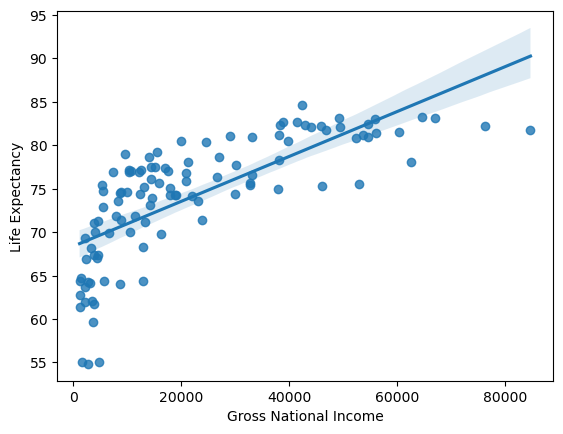

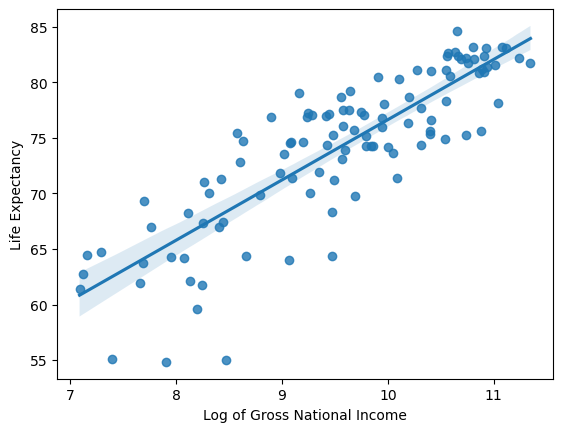

Slope of Model: [5.3004731] 
Intercept of Model: 23.821047166851173
Train RMSE: 3.538745187233812 
Test RMSE: 4.186771674461889


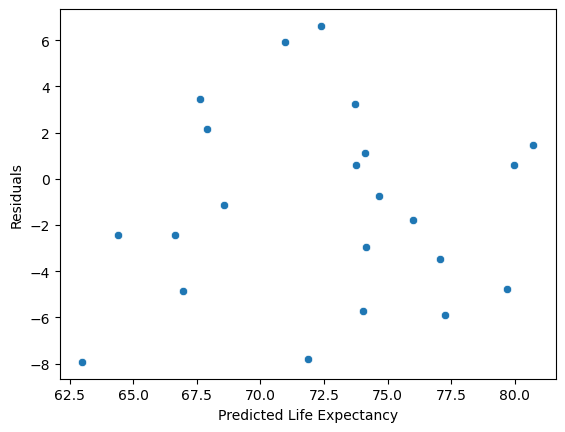

                                 OLS Regression Results                                
Dep. Variable:        Life Expectancy   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          3.023e+04
Date:                Sun, 20 Nov 2022   Prob (F-statistic):                   4.62e-134
Time:                        13:38:26   Log-Likelihood:                         -317.28
No. Observations:                 109   AIC:                                      636.6
Df Residuals:                     108   BIC:                                      639.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [48]:
X = (df_h3["Gross national income (GNI) per capita"].to_numpy().reshape(-1,1))
sns.regplot(x = X,y = y).set(xlabel='Gross National Income', ylabel='Life Expectancy')
plt.show()
#Used log transformation because data showed strong log(x) type, diminishing returns curve
X = np.log(df_h3["Gross national income (GNI) per capita"].to_numpy().reshape(-1,1))
y = (df_h3["Life Expectancy"])
sns.regplot(x = X,y = y).set(xlabel='Log of Gross National Income', ylabel='Life Expectancy')
plt.show()
schooling_train, schooling_test, exp_train, exp_test = train_test_split(X, y, test_size=0.2, random_state=94)
model_h3 = LinearRegression().fit(schooling_train,exp_train)
train_predictions = model_h3.predict(schooling_train)
test_predictions = model_h3.predict(schooling_test)
train_residuals = exp_train - train_predictions
test_residuals = exp_test - test_predictions
print("Slope of Model:",model_h3.coef_,"\nIntercept of Model:",model_h3.intercept_)
train_rmse = np.sqrt(np.mean(train_residuals**2))
test_rmse = np.sqrt(np.mean(test_residuals**2))
print("Train RMSE:",train_rmse,"\nTest RMSE:",test_rmse)
sns.scatterplot(x = test_predictions, y = test_residuals).set(xlabel='Predicted Life Expectancy', ylabel='Residuals')
plt.show()
OLS_model_h3 = sm.OLS(y, X).fit()
print(OLS_model_h3.summary())
print("\nRight-sided P-Value at 97.5% CL:",OLS_model_h3.t_test(1).pvalue)

Our linear regression yields an R squared value of 0.996, suggesting very strong correlation between the log GNI per capita of a country and that country's life expectancy. Our train RMSE is lower than our test RMSE which suggests that our model may be overfitting. Additionally, when running a correlation test to analyze our hypothesis, we can reject the null hypothesis and predict that countries with higher gross national incomes have higher life expectancies with a confidence level of 97.5%. Because our two-sided test with CL 95% yields a p-value of approximately 0, we can conclude that our right-side test would have the same p-value with a CL of 97.5%. This gives us a type I error probability of 2.5%. The model intercepts predicts that a country with a GNI of 1 would have a life expectancy of 23.82 years. The model also predicts that a 172%, (1-e)/100, increase in a country's GNI per capita will increase their life expectancy by 5.3 years.

## Are happier people living longer?
   * H0: A country’s average happiness does not affect their citizens’ life expectancies.
   * HA: People from countries with higher happiness levels live longer. 

In [12]:
#setup and run regression
X = df_final["happiness_index"].to_numpy().reshape(-1,1)
y = df_final["Life Expectancy"]
happy_train, happy_test, exp_train, exp_test = train_test_split(X, y, test_size=0.2)
model_h4 = LinearRegression().fit(happy_train,exp_train)
print("Slope of Model:",model_h4.coef_,"\nIntercept of Model:",model_h4.intercept_)

#get errors
train_residuals = exp_train - model_h3.predict(happy_train)
test_residuals = exp_test - model_h3.predict(happy_test)
train_rmse = np.sqrt(np.mean(train_residuals**2))
test_rmse = np.sqrt(np.mean(test_residuals**2))
print("Train RMSE:",train_rmse,"\nTest RMSE:",test_rmse,)

#plot regression
# sns.regplot(x = X,y = y).set(xlabel='Happiness', ylabel='Life Expectancy')
OLS_model_h4 = sm.OLS(y, X).fit()
print(OLS_model_h4.summary())

Slope of Model: [4.65791317] 
Intercept of Model: 48.04287051528894
Train RMSE: 21.095483485205726 
Test RMSE: 19.53442999236851
                                 OLS Regression Results                                
Dep. Variable:        Life Expectancy   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                              6484.
Date:                Sun, 20 Nov 2022   Prob (F-statistic):                    2.93e-98
Time:                        13:19:24   Log-Likelihood:                         -400.47
No. Observations:                 109   AIC:                                      802.9
Df Residuals:                     108   BIC:                                      805.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                          

The model that we have here gives us a t-statistic of 80 and a p-value of 0, indicating that this model is spooky and that we can safely reject the null hypothesis. Thus, there is a correlation between happiness and life expectancies for the countries in our dataset. 

Given that train RMSE < test RMSE, we are not overfitting either. The slope of 5 is also rather significant; a unit increase in happiness results in a half decade increase in life.  

## Do people in countries with UHC (Universal Healthcare) live longer?
   * H0: People from countries with UHC live as long as people from countries without UHC. 
   * HA: People from countries with UHC live longer than people from countries without UHC.

Median Life Expectancy of Countries without UHC: 71.61 years
Median Life Expectancy of Countries with UHC: 77.46 years
Sample Difference in the Medians: 5.85 years


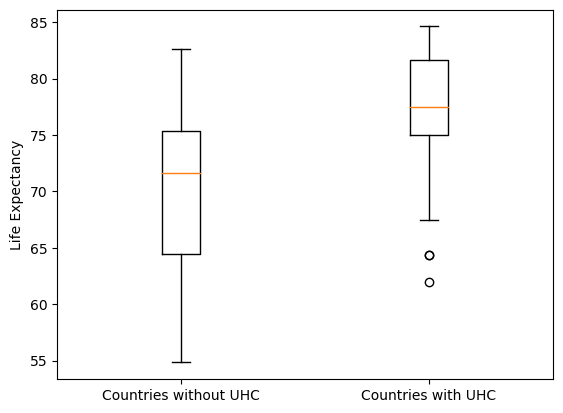

In [13]:
X = df_final["has_uhc"]
y = df_final["Life Expectancy"]

# Life Expectancy datasets according to presence of UHC
y_has_uhc = y[X == 1.0]
y_no_uhc = y[X != 1.0]

# Boxplot
fig, ax = plt.subplots()
ax.boxplot([y_no_uhc, y_has_uhc])
plt.xticks([1, 2], ["Countries without UHC", "Countries with UHC"])
plt.ylabel("Life Expectancy")
plt.show

# Sample Difference
print("Median Life Expectancy of Countries without UHC:", round(y_no_uhc.median(),2), "years")
print("Median Life Expectancy of Countries with UHC:", y_has_uhc.median(), "years")
sample_diff = round(y_has_uhc.median() - y_no_uhc.median(), 2)
print("Sample Difference in the Medians:", sample_diff, "years")

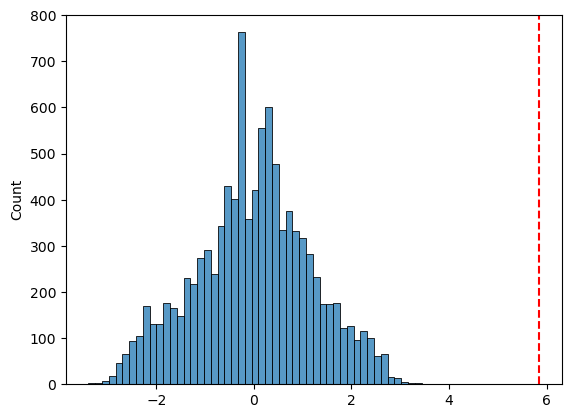

In [14]:
# Permutation Test
perm_diff = np.zeros(10000)
for i in range(10000):
    perm_X = np.random.choice(X, X.size, replace = False)
    perm_y_has_uhc = y[perm_X == 1.0]
    perm_y_no_uhc = y[perm_X != 1.0]
    perm_diff[i] = round(perm_y_has_uhc.median() - perm_y_no_uhc.median(), 2)

# Plot result
sns.histplot(perm_diff)
plt.axvline(sample_diff, color='r', ls='--')

In [15]:
# Interpretation
perm_mean = perm_diff.mean()
perm_std = perm_diff.std()
std_diff = (sample_diff - perm_mean)/perm_std

print("Mean:", round(perm_mean, 2))
print("Standard Deviation:", round(perm_std, 2))
print("Sample difference is", round(std_diff, 2), "standard deviations away from the mean")
print("p-value:", stats.norm.sf(std_diff))

Mean: -0.02
Standard Deviation: 1.19
Sample difference is 4.93 standard deviations away from the mean
p-value: 4.1594835100944057e-07


The p-value is significantly less than the significance level of 0.05, so we reject the null hypothesis that people from countries with UHC live as long as people from countries without UHC.

# Interpretations for Preregistrations

- Do people that eat more live longer? YES, significantly.
- Are more educated people living longer? YES, significantly.
- Do people with higher income live longer? YES, significantly.
- Are happier people living longer? YES, significantly.
- Do countries with universal healthcare have longer living citizens? Inconclusive.

We now have an idea of what factors attribute to longer life expectancies, but it would be remiss to not acknowledge that many of these are likely correlated. First world countries simply have more resources to send people to school, eat more, and spend more to live happily. Thus, the next section of our analysis will focus on identifying life expectancy-influencing factors that are as isolated, or non-collinear, as possible.


## Collinearity Matrix

We can see below that several of our pre-registered analyses consisted of highly collinear variables; `level of human development` is collinear with `mean years of schooling`, etc.

<AxesSubplot:>

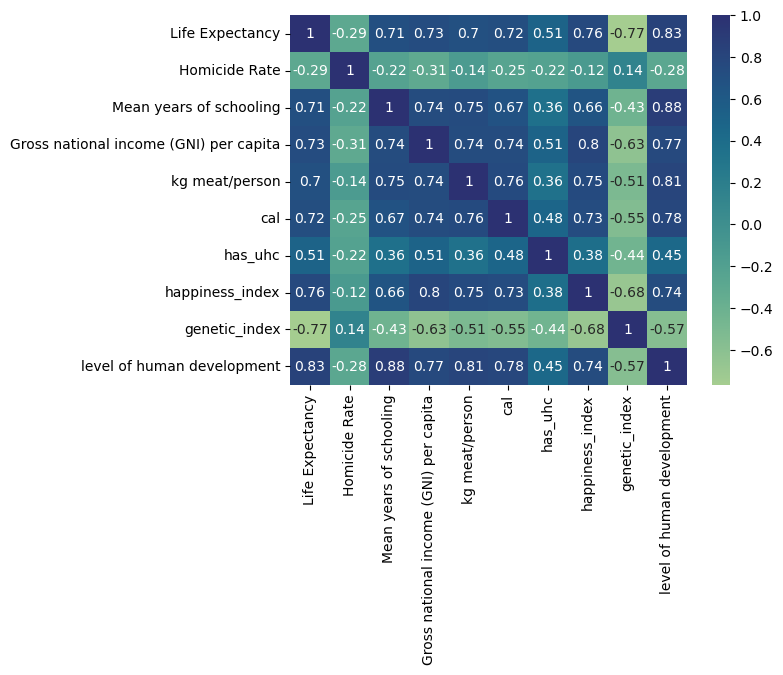

In [17]:
collinearity_matrix = df_final.iloc[:,1:].corr()
sns.heatmap(collinearity_matrix, xticklabels=collinearity_matrix.columns,yticklabels=collinearity_matrix.columns,cmap="crest", annot=True)

## Remove Highly Collinear Variables

Given the collineary matrix above, we can see a high amount of collinearity between many of the variables. Removing those with a value > 0.7 leaves us with homicide rate, GNI per capita, whether or not a country has UHC, and the genetic index. 

<AxesSubplot:>

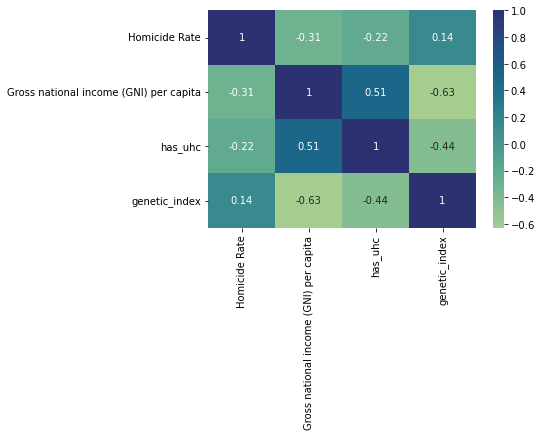

In [8]:
#Remove Collinearity by Making Sure no Two Variates Have >.7 Correlation
collinearity_matrix2 = df_final[["Homicide Rate","Gross national income (GNI) per capita","has_uhc","genetic_index"]].corr()
sns.heatmap(collinearity_matrix2, xticklabels=collinearity_matrix2.columns,yticklabels=collinearity_matrix2.columns,cmap="crest", annot=True)

## Multivariate Regression Model (With Pruned Variables)

We make a multivariate regression, but with the highly collinear variables removed. We first isolate each variable and graph it in comparison to life expectancy to check for non-linear or heteroskedastic behavior.

#### GNI per capita: non-linear; log transform needed

Below is a chart showing GNI per capita vs Life expectancy. Given its non-linear shape, we need to apply a log transform.

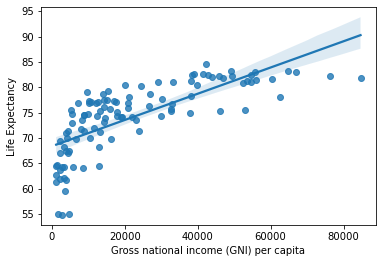

/var/folders/4p/cy8bz0pn31n_9_zx91tl53wh0000gn/T/ipykernel_97475/3063140501.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model2["Log GNI per Capita"] = np.log(df_final["Gross national income (GNI) per capita"])


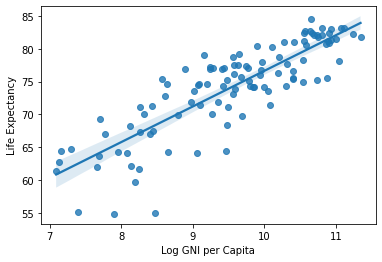

In [9]:
#Determine Possible Transformations
sns.regplot(data = df_final, x = "Gross national income (GNI) per capita",y = "Life Expectancy")
plt.show()
#From Hypothesis 3, we know we need to use a log transformation on GNI per capita
df_model2 = df_final[["Country","Life Expectancy"]]
df_model2["Log GNI per Capita"] = np.log(df_final["Gross national income (GNI) per capita"])
sns.regplot(data = df_model2, x = "Log GNI per Capita",y = "Life Expectancy")
plt.show()

#### Homicide Rate: heteroskedastic; log transform applied

The residual error plot below appears to be conic, indicating heterskedasticity. Applying a log transform seems to fix this problem, and creates a much more random residual error plot.

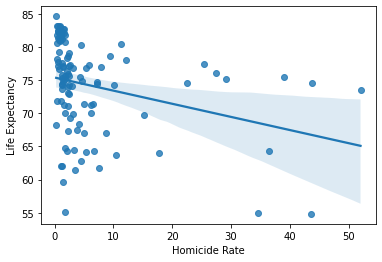

/var/folders/4p/cy8bz0pn31n_9_zx91tl53wh0000gn/T/ipykernel_97475/2062338394.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model2["Log Homicide Rate"] = np.log(df_final["Homicide Rate"])


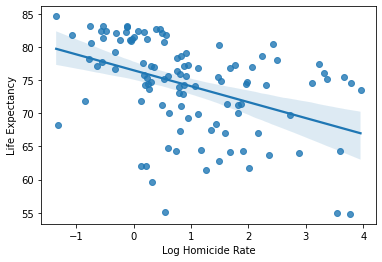

In [10]:
#Homicide Rate Transformations
sns.regplot(data = df_final, x = "Homicide Rate",y = "Life Expectancy")
plt.show()
#Showing high heteroskedastic behavior, need to apply a transformation that reduces variation as homicide rate increases
df_model2["Log Homicide Rate"] = np.log(df_final["Homicide Rate"])
sns.regplot(data = df_model2, x = "Log Homicide Rate",y = "Life Expectancy")
plt.show()

#### has_UHC: binary variable; no tansform possible

Whether or not a country has universal healthcare is binary, so no transform will really improve predictions.

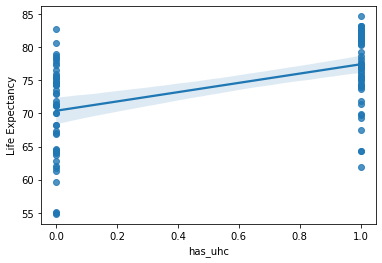

/var/folders/4p/cy8bz0pn31n_9_zx91tl53wh0000gn/T/ipykernel_97475/451485941.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model2["has_uhc"] = df_final["has_uhc"]


In [11]:
#Has universal healthcare is already binary. Thus, no transformation could improve the prediction
sns.regplot(data = df_final, x = "has_uhc",y = "Life Expectancy")
plt.show()
df_model2["has_uhc"] = df_final["has_uhc"]

#### Genetic Index: linear already; no transforms needed

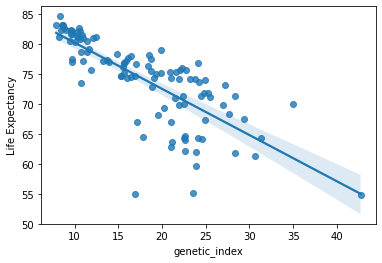

/var/folders/4p/cy8bz0pn31n_9_zx91tl53wh0000gn/T/ipykernel_97475/3196094658.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model2["genetic_index"] = df_final["genetic_index"]


In [12]:
#Genetic index transformation
sns.regplot(data = df_final, x = "genetic_index",y = "Life Expectancy")
plt.show()
#Data already looks linear
df_model2["genetic_index"] = df_final["genetic_index"]

In [13]:
#df_model2 = df_model2.set_index("Country")
df_model2.head()

,Country,Life Expectancy,Log GNI per Capita,Log Homicide Rate,has_uhc,genetic_index
0,Albania,78.686,9.556134,0.828552,1.0,11.4
1,United Arab Emirates,78.120,11.044099,-0.776529,1.0,18.5
2,Argentina,76.813,9.948713,1.671473,1.0,15.7
3,Armenia,75.224,9.484785,0.524729,0.0,19.9
4,Australia,83.200,10.804430,-0.116534,1.0,8.6


# Interpretation and Conclusions



## Overfitting Analysis: Residuals
In the residual plot, our model shows approximately randomly placed residuals, indicating that the model is making predictions on a linear set of data.

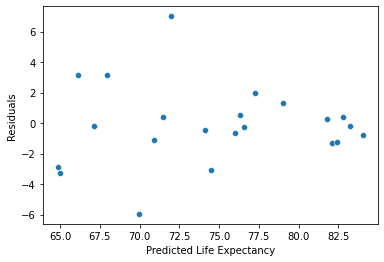

In [15]:
sns.scatterplot(x = test_predictions, y = test_residuals).set(xlabel='Predicted Life Expectancy', ylabel='Residuals')
plt.show()

## Overfitting Analysis: Errors

The model's test RMSE is also much lower than the train RMSE which suggests that the model is not overfitting. The R squared values also suggest that the model is not overfitting, since the test R squared value is higher than the train R squared.

In [14]:
#Model creation
X = df_model2[["Log Homicide Rate","Log GNI per Capita","has_uhc","genetic_index"]]
y = df_model2["Life Expectancy"]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)
model2 = LinearRegression().fit(x_train,y_train)
train_predictions = model2.predict(x_train)
test_predictions = model2.predict(x_test)
train_residuals = y_train - train_predictions
test_residuals = y_test - test_predictions
train_rmse = np.sqrt(np.mean(train_residuals**2))
test_rmse = np.sqrt(np.mean(test_residuals**2))
print("Train RMSE:",train_rmse,"\nTest RMSE:",test_rmse)
print("Train R Squared",model2.score(x_train,y_train),"\nTest R Squared",model2.score(x_test,y_test))
print("Intercept", model2.intercept_)
slopes_model2 = pd.DataFrame(data = model2.coef_.reshape(1,4),columns = X.iloc[:,:].columns)
slopes_model2.head()

Train RMSE: 3.0456957294355784 
Test RMSE: 2.5684689149938285
Train R Squared 0.8065354963461845 
Test R Squared 0.8570953840002471
Intercept 43.69382237957403


,Log Homicide Rate,Log GNI per Capita,has_uhc,genetic_index
0,-0.328758,3.903525,-0.030636,-0.359759


## Model Coefficients Analysis

In [16]:
slopes_model2.head()

,Log Homicide Rate,Log GNI per Capita,has_uhc,genetic_index
0,-0.328758,3.903525,-0.030636,-0.359759


- The model's intercept predicts that a country with metrics of a homicide rate of 1, gross national income per capita of 1, no universal healthcare, and a zero genetic index (zero heart disease and late stage diseases) would have a life expectancy of 43.69 years. 

- The homicide rate coefficient predicts that a country's life expectancy will decrease by 0.33 years as homicide rate increases by 172%, (1-e)/100.

- The GNI per capita coefficient predicts that a country's life expectancy will increase by 3.90 years as homicide rate increases by 172%, (1-e)/100. 

- The Universal Healthcare coefficient predicts that a country's life expectancy will decrease by 0.03 years if the country has UHC. This coefficient is suprising because it would be expected that while UHC not only increases life expectancy by providing more care to its people, but also that countries with UHC tend to already be more developed. However, this coefficient is low and may be an artifact of the model and reminents of collinearity shifting weight towards another variate. 

- The genetic index coefficient predicts that a country's life expectancy will decrease by 0.36 years as their genetic index (measure of people with heart disease and late state diseases) increases by one. 

## The Perfect Country

This section will analyse which countries are performing best in each variate category. Then, the metrics from the best performing categories will be combined to find the life expectancy for "The Perfect Country".

In [189]:
slopes_model2.head()

,Log Homicide Rate,Log GNI per Capita,has_uhc,genetic_index
0,-0.328758,3.903525,-0.030636,-0.359759


#### Finding the best country for each variable

For variables with a negative slope, we will find the minimum value in our dataset. For variables with a positive slope, we will find the value a maximum.

In [221]:
#Find Minimum Value Country for Negative Coefficients and Maximum Value Countries for Positive Coefficients

# Country with lowest Log Homicide Rate
country_minHomicide = df_model2["Log Homicide Rate"].idxmin()
minHomicide = df_model2.loc[country_maxGNI,"Log Homicide Rate"]
print("The country with the lowest Log Homicide Rate is",country_minHomicide,"with",minHomicide)

# Country with highest Log GNI per Capita
country_maxGNI = df_model2["Log GNI per Capita"].idxmax()
maxGNI = df_model2.loc[country_maxGNI,"Log GNI per Capita"]
print("The country with the highest Log GNI Per Capita is",country_maxGNI,"with",maxGNI)

# has_uhc has a negative coefficient, so a country without universal healthcare will be used for the perfect country

# Country with the lowest genetic index for heart disease and later-life diseases
country_minGenetics = df_model2["genetic_index"].idxmin()
minGenetics = df_model2.loc[country_minGenetics,"genetic_index"]
print("The country with the lowest genetic index is",country_minGenetics,"with",minGenetics)

The country with the lowest Log Homicide Rate is Japan with -1.0788096613719298
The country with the highest Log GNI Per Capita is Luxembourg with 11.34627418163535
The country with the lowest genetic index is Switzerland with 7.9


Therefore, the perfect realistic country for our model would have Luxembourg's high GNI per capita, Japan's low homicide rate, no universal healthcare, and Switzerland's low genetic index for late life diseases.

In [232]:
# Finding our perfect country's life expectancy
perfectCountry = pd.DataFrame({"Log Homicide Rate":[minHomicide],
                            "Log GNI per Capita":[maxGNI],
                            "has_uhc":[0],
                            "genetic_index":[minGenetics]})
print("Perfect Country Life Expectancy",f'{model2.predict(perfectCountry)[0]:.2f}')

# Actual highest life expectancy
country_maxExp = df_model2["Life Expectancy"].idxmax()
maxExp = df_model2.loc[country_maxExp,"Life Expectancy"]
print("The country with the actual highest Life Expectancy is",country_maxExp,"with",f'{maxExp:.2f}')

Perfect Country Life Expectancy 85.50
The country with the actual highest Life Expectancy is Japan with 84.62


Our perfect country, made up of other countrys' metrics, is expected to have a life expectancy of 85.50 years, beating the country with the actual highest life expectancy, Japan, by 0.88 years.

# Conclusion

This project aimed to analyze and answer how life expectancies are affected by socioeconomic factors like violent crime rates, healthcare, diet, economic development, genetics, and happiness. We came to the conclusion that many of them, like food consumption, education, income, and happiness significantly affect life expectancies across the globe. We were surprised to find, however, that universal healthcare did not significantly impact life expectancy.

We later confirmed that many of these factors expected of first world countries were collinear, that they had strong effects on one another and on life expectancy. Isolating for factors that did were not highly collinear left us with just four factors: homicide rate, GNI per capita, universal healthcare, and genetic index. Further analysis found that the perfect country is not a singular entity but rather a combination of multiple countries. 

In conclusion, life expectancy is a complicated metric with many factors that affect one another strongly. Factors like income and happiness are indeed important, but are also not independent of one another. If we want to live longer, it's not only about deepening our pockets or pursuing happiness, but rather a combination of those two and many others as well.

# Data Limitations

As briefly mentioned in the data description, certain countries lack updated statistics, or any statistics for that matter, which may lead to inaccuracies in our analysis and reduces the number of usable countries in our data. It is also important to note that certain geographic regions are countries to certain organizations and not countries to others. This problem of classification extends to territories, like French Guiana, Crown Dependencies, etc. Our dataset may also have some variates that are too highly correlated, see the matrix below, which leads to a model that may be harder to interpret.

# Source Code

# Acknowledgements